<a href="https://colab.research.google.com/github/Kostia9/Data-Analysis-2025/blob/main/diabetes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0) Imports


In [1]:
import sys, os, math, json, warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import (
    train_test_split, StratifiedKFold, GridSearchCV, cross_val_score,
    cross_val_predict, learning_curve
)
from sklearn.metrics import (
    classification_report, confusion_matrix, ConfusionMatrixDisplay,
    roc_auc_score, average_precision_score, precision_recall_curve
)
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.compose import ColumnTransformer, make_column_selector as selector
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.inspection import permutation_importance

rng = 42
print("Python:", sys.version.split()[0])
import sklearn
print("sklearn:", sklearn.__version__)


Python: 3.12.11
sklearn: 1.6.1


# 1) Load data

In [2]:
URL = "https://drive.google.com/uc?id=1WKilPKrSUieMhddMtGn2LIehO18X2SpF"
df = pd.read_csv(URL)

print("Колонки:", list(df.columns))
print("Розмір датасета:", df.shape)

zero_is_missing = ['Glucose','BloodPressure','SkinThickness','Insulin','BMI']
df[zero_is_missing] = df[zero_is_missing].replace(0, np.nan)

print("\nК-сть пропусків по колонках:")
print(df.isnull().sum().sort_values(ascending=False))


Колонки: ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome']
Розмір датасета: (768, 9)

К-сть пропусків по колонках:
Insulin                     374
SkinThickness               227
BloodPressure                35
BMI                          11
Glucose                       5
Pregnancies                   0
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64


# 2) Train/Test split


In [3]:
X = df.drop(columns=['Outcome'])
y = df['Outcome'].astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=rng
)
print("\nРозміри: X_train", X_train.shape, "X_test", X_test.shape)



Розміри: X_train (614, 8) X_test (154, 8)


# 3) EDA

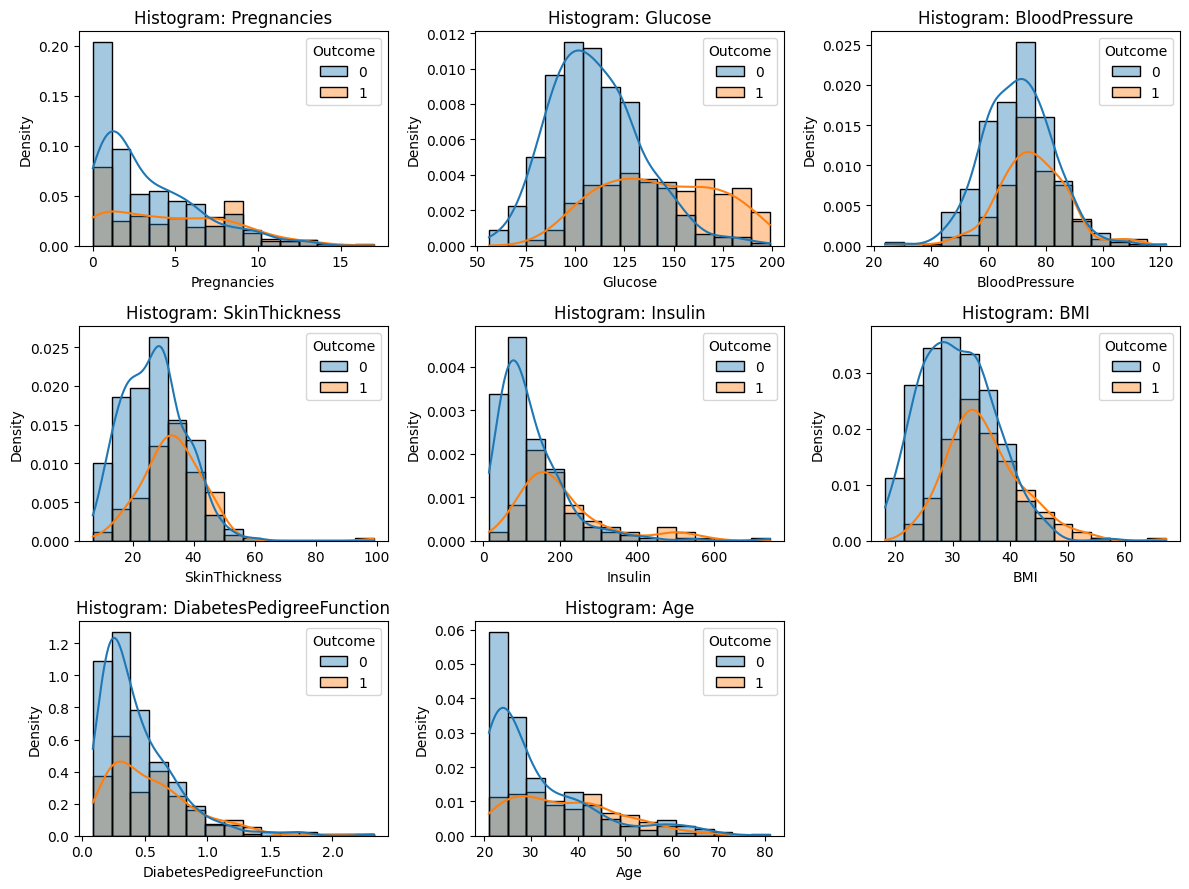

In [4]:
cols = X_train.columns.tolist()
n_cols = len(cols)
nrows = int(np.ceil(n_cols / 3))
fig, axes = plt.subplots(nrows, 3, figsize=(12, 3*nrows))
axes = axes.flatten()

for i, col in enumerate(cols):
    ax = axes[i]
    sns.histplot(
        data=X_train.assign(Outcome=y_train),
        x=col,
        hue="Outcome",
        bins=15,
        kde=True,
        stat="density",
        alpha=0.4,
        ax=ax
    )
    ax.set_title(f'Histogram: {col}')
    ax.set_xlabel(col)
    ax.set_ylabel('Density')

# прибрати порожні осі
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


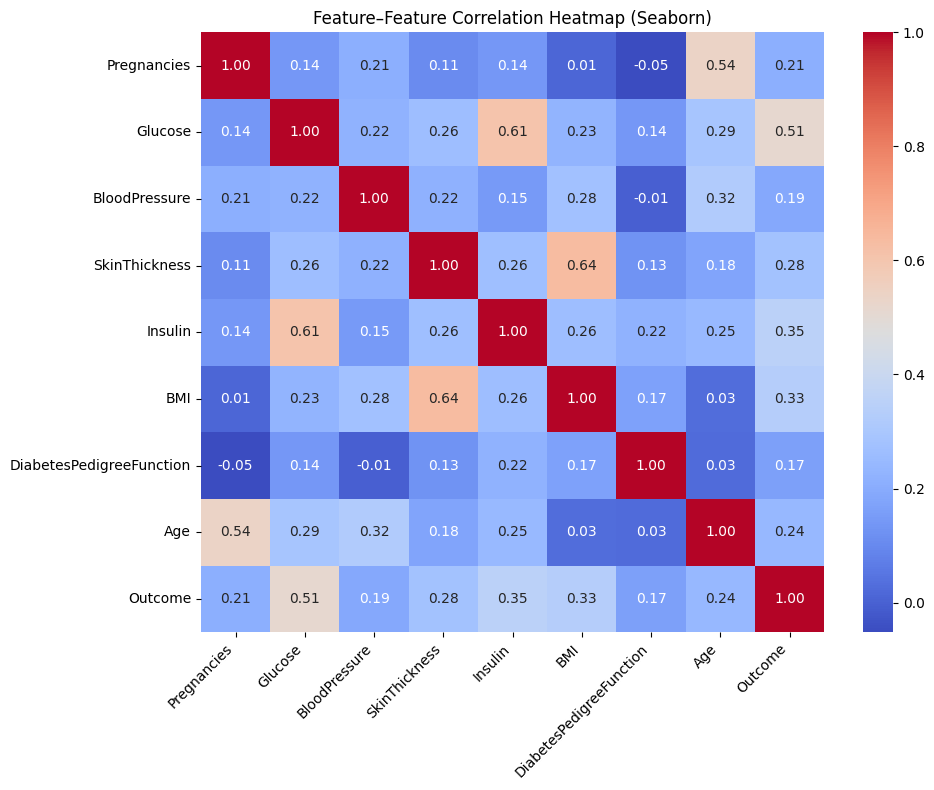

In [5]:
# 3.2 Кореляційна матриця між ознаками
df_train = X_train.assign(Outcome=y_train)
corr = df_train.corr(numeric_only=True)
plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm")
plt.title('Feature–Feature Correlation Heatmap (Seaborn)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

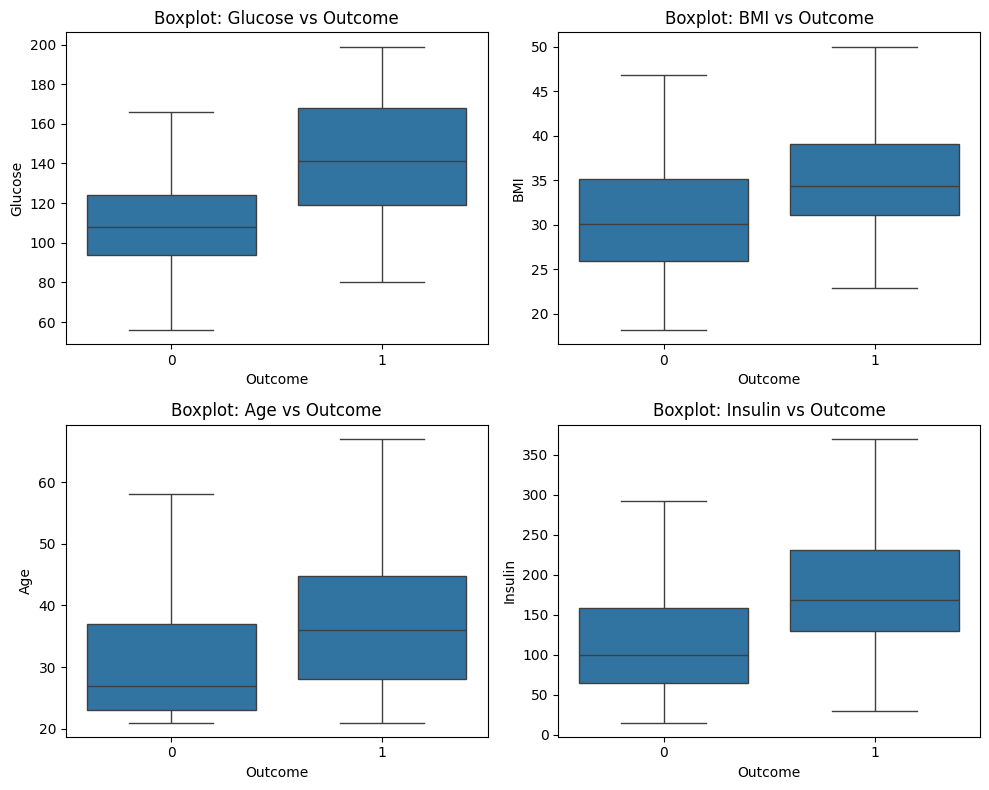

In [6]:
# 3.3 Boxplot-и декількох ознак відносно Outcome
box_feats = ['Glucose','BMI','Age','Insulin']

# Combine X_train and y_train for easier plotting with seaborn
df_train_plot = X_train.copy()
df_train_plot['Outcome'] = y_train

n_cols = 2  # Number of columns for subplots
n_rows = int(np.ceil(len(box_feats) / n_cols))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
axes = axes.flatten()

for i, feat in enumerate(box_feats):
    sns.boxplot(data=df_train_plot, x='Outcome', y=feat, showfliers=False, ax=axes[i])
    axes[i].set_title(f'Boxplot: {feat} vs Outcome')
    axes[i].set_xlabel('Outcome')
    axes[i].set_ylabel(feat)

# Remove any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

# 4) Preprocessing and normalization

In [7]:
num_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

preprocessor = ColumnTransformer(
    transformers=[("num", num_pipe, selector(dtype_include=np.number))],
    remainder="drop"
)

# 5) Model sweep and hyperparameter tuning

In [8]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=rng)

In [10]:
# --- 5.1 GridSearch для KNN
knn_pipe = Pipeline([("prep", preprocessor), ("clf", KNeighborsClassifier())])
knn_grid = {
    "clf__n_neighbors": [3, 5, 7, 11, 15],
    "clf__weights": ["uniform", "distance"],
    "clf__metric": ('minkowski', 'chebyshev')
}
knn_gs = GridSearchCV(knn_pipe, knn_grid, scoring="f1", cv=cv, n_jobs=-1, verbose=0)
knn_gs.fit(X_train, y_train)
best_knn = knn_gs.best_estimator_
print("\nKNN best params:", knn_gs.best_params_)
print(f"KNN best CV F1: {knn_gs.best_score_:.3f}")


KNN best params: {'clf__metric': 'chebyshev', 'clf__n_neighbors': 7, 'clf__weights': 'distance'}
KNN best CV F1: 0.648


In [11]:
# --- 5.2 GridSearch для SVM (RBF)
svm_pipe = Pipeline([("prep", preprocessor), ("clf", SVC(probability=True, class_weight='balanced', random_state=rng))])

svm_grid = {
    "clf__kernel": ["rbf"],
    "clf__C": [0.1, 1, 3, 5, 10, 30],
    "clf__gamma": ["scale", 0.001, 0.01, 0.03, 0.1, 0.3, 1.0],
}
svm_gs = GridSearchCV(svm_pipe, svm_grid, scoring="f1", cv=cv, n_jobs=-1, verbose=0)
svm_gs.fit(X_train, y_train)
best_svm = svm_gs.best_estimator_
print("\nSVM best params:", svm_gs.best_params_)
print(f"SVM best CV F1: {svm_gs.best_score_:.3f}")


SVM best params: {'clf__C': 3, 'clf__gamma': 0.1, 'clf__kernel': 'rbf'}
SVM best CV F1: 0.701


In [12]:
# --- 5.3 GridSearch для Decision Tree
dt_pipe = Pipeline([("prep", preprocessor), ("clf", DecisionTreeClassifier(random_state=rng))])

dt_grid = {
    "clf__max_depth": [3, 5, 7, 10, None],
    "clf__min_samples_split": [2, 5, 10],
    "clf__min_samples_leaf": [1, 2, 4],
    "clf__criterion": ["gini", "entropy"]
}
dt_gs = GridSearchCV(dt_pipe, dt_grid, scoring="f1", cv=cv, n_jobs=-1, verbose=0)
dt_gs.fit(X_train, y_train)
best_dt = dt_gs.best_estimator_
print("\nDecision Tree best params:", dt_gs.best_params_)
print(f"Decision Tree best CV F1: {dt_gs.best_score_:.3f}")


Decision Tree best params: {'clf__criterion': 'gini', 'clf__max_depth': 5, 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 2}
Decision Tree best CV F1: 0.588


In [13]:
# --- 5.4 GridSearch для Random Forest

rf_pipe = Pipeline([("prep", preprocessor), ("clf", RandomForestClassifier(random_state=rng))])

rf_grid = {
    "clf__n_estimators": [50, 100],
    "clf__max_depth": [4, 8],
    "clf__min_samples_split": [5, 10],
    "clf__min_samples_leaf": [2, 4],
    "clf__max_features": ['sqrt', 0.5, 1.0],
    "clf__class_weight": ['balanced_subsample', 'balanced']
}

rf_gs = GridSearchCV(rf_pipe, rf_grid, scoring="f1", cv=cv, n_jobs=-1, verbose=1)
rf_gs.fit(X_train, y_train)
best_rf = rf_gs.best_estimator_
print("\nDecision Tree best params:", rf_gs.best_params_)
print(f"Decision Tree best CV F1: {rf_gs.best_score_:.3f}")

Fitting 5 folds for each of 96 candidates, totalling 480 fits

Decision Tree best params: {'clf__class_weight': 'balanced_subsample', 'clf__max_depth': 4, 'clf__max_features': 0.5, 'clf__min_samples_leaf': 2, 'clf__min_samples_split': 10, 'clf__n_estimators': 50}
Decision Tree best CV F1: 0.712


In [14]:
# --- 5.5 GridSearch для AdaBoost
ab_pipe = Pipeline([("prep", preprocessor), ("clf", AdaBoostClassifier(random_state=rng))])

ab_grid = {
    "clf__n_estimators": [50, 70, 90, 120, 180, 200],
    "clf__learning_rate": [0.001, 0.01, 0.1, 1, 10],
}
ab_gs = GridSearchCV(ab_pipe, ab_grid, scoring="recall", cv=cv, n_jobs=-1, verbose=1)
ab_gs.fit(X_train, y_train)
best_ab = ab_gs.best_estimator_
print("\nAdaBoost best params:", ab_gs.best_params_)
print(f"AdaBoost best CV F1: {ab_gs.best_score_:.3f}")

Fitting 5 folds for each of 30 candidates, totalling 150 fits

AdaBoost best params: {'clf__learning_rate': 1, 'clf__n_estimators': 70}
AdaBoost best CV F1: 0.608


# 6) Selecting the best models

In [15]:
candidates = {
    "KNN": best_knn,
    "SVM": best_svm,
    "RandomForest": best_rf,
    "DecisionTree": best_dt,
    "AdaBoost": best_ab
}

def fit_and_pick_threshold(pipe, X_tr, y_tr, cv):
    oof_proba = cross_val_predict(pipe, X_tr, y_tr, cv=cv, method="predict_proba", n_jobs=-1)[:,1]
    prec, rec, thr = precision_recall_curve(y_tr, oof_proba)
    f1s = 2*prec[1:]*rec[1:] / (prec[1:] + rec[1:] + 1e-12)
    best_idx = np.argmax(f1s)
    best_thr = thr[best_idx]
    return best_thr, f1s[best_idx]

thresholds = {}
for name, est in candidates.items():
    thr, f1oof = fit_and_pick_threshold(est, X_train, y_train, cv)
    thresholds[name] = (thr, f1oof)
    print(f"{name:14s} OOF-best thr = {thr:.3f} | OOF F1 = {f1oof:.3f}")


KNN            OOF-best thr = 0.266 | OOF F1 = 0.675
SVM            OOF-best thr = 0.337 | OOF F1 = 0.708
RandomForest   OOF-best thr = 0.504 | OOF F1 = 0.713
DecisionTree   OOF-best thr = 0.130 | OOF F1 = 0.640
AdaBoost       OOF-best thr = 0.456 | OOF F1 = 0.681


# 7) Final test score


=== Підсумок (Test set) — сортування за F1(клас=1) ===
RandomForest   F1(1)=0.672 | Recall(1)=0.759 | ROC-AUC=0.813 | AP=0.683 | thr=0.504
SVM            F1(1)=0.667 | Recall(1)=0.778 | ROC-AUC=0.816 | AP=0.675 | thr=0.337
DecisionTree   F1(1)=0.667 | Recall(1)=0.833 | ROC-AUC=0.762 | AP=0.585 | thr=0.130
AdaBoost       F1(1)=0.667 | Recall(1)=0.759 | ROC-AUC=0.817 | AP=0.686 | thr=0.456
KNN            F1(1)=0.607 | Recall(1)=0.759 | ROC-AUC=0.754 | AP=0.615 | thr=0.266

=== Матриці невідповідностей (Test set) ===


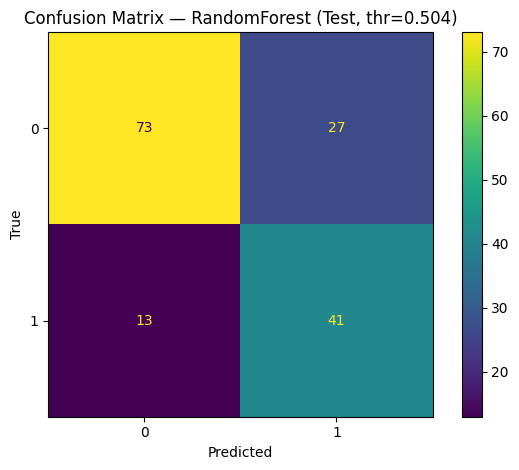

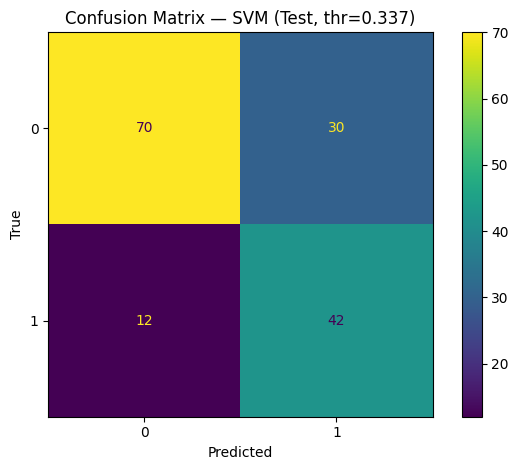

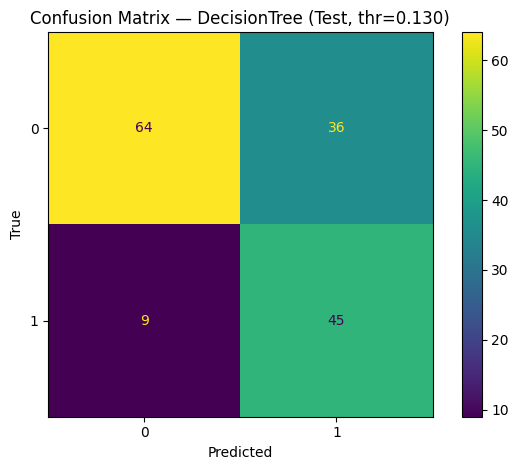

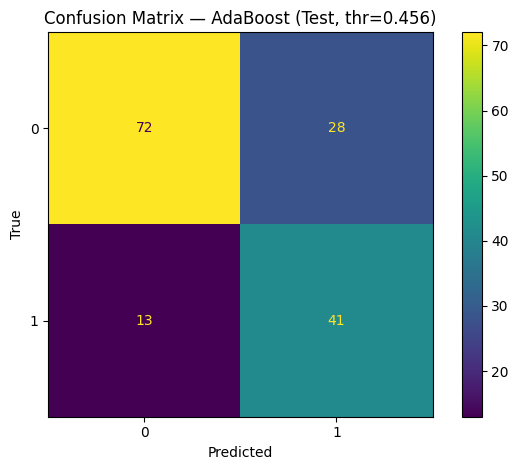

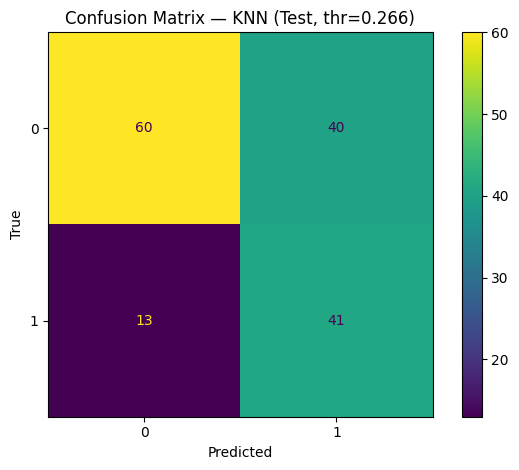

In [22]:
results = []
for name, est in candidates.items():
    est.fit(X_train, y_train)
    proba = est.predict_proba(X_test)[:,1]
    thr = thresholds[name][0]
    y_pred = (proba >= thr).astype(int)
    roc = roc_auc_score(y_test, proba)
    ap  = average_precision_score(y_test, proba)
    rep = classification_report(y_test, y_pred, output_dict=True)
    f1  = rep['1']['f1-score']
    recall = rep['1']['recall']
    results.append((name, f1, roc, ap, thr, est, y_pred, recall))

# Сортуємо за F1 класу 1
results.sort(key=lambda x: x[1], reverse=True)
print("\n=== Підсумок (Test set) — сортування за F1(клас=1) ===")
for name, f1, roc, ap, thr, _, _, recall in results: # отримуємо recall з результатів
    print(f"{name:14s} F1(1)={f1:.3f} | Recall(1)={recall:.3f} | ROC-AUC={roc:.3f} | AP={ap:.3f} | thr={thr:.3f}") # виводимо recall


print("\n=== Матриці невідповідностей (Test set) ===")
for name, f1, roc, ap, thr, est, y_pred, recall in results: # ітеруємо по всіх результатах
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['0','1'])
    disp.plot(values_format='d')
    plt.title(f'Confusion Matrix — {name} (Test, thr={thr:.3f})')
    plt.xlabel('Predicted'); plt.ylabel('True')
    plt.tight_layout()
    plt.show()

# 8) Permutation importance

In [17]:
print("\n=== Permutation importance ===")

for name, f1, roc, ap, thr, est, y_pred, recall in results:
    print(f"\n--- {name} ---")
    r = permutation_importance(est, X_test, y_test, n_repeats=20, random_state=rng, n_jobs=-1, scoring='f1')
    importances_mean = r.importances_mean
    importances_std = r.importances_std
    feat_names_plain = list(X.columns)
    order = np.argsort(-importances_mean)

    for idx in order:
        print(f"{feat_names_plain[idx]:28s} {importances_mean[idx]: .5f} ± {importances_std[idx]: .5f}")


=== Permutation importance ===

--- RandomForest ---
Glucose                       0.14025 ±  0.03336
BMI                           0.05106 ±  0.02891
Age                           0.03437 ±  0.02057
Pregnancies                   0.02175 ±  0.00750
Insulin                       0.01616 ±  0.01705
BloodPressure                 0.00494 ±  0.00546
SkinThickness                -0.00336 ±  0.00565
DiabetesPedigreeFunction     -0.00774 ±  0.00744

--- SVM ---
Glucose                       0.10879 ±  0.02951
Age                           0.07112 ±  0.02627
BMI                           0.04198 ±  0.01840
DiabetesPedigreeFunction      0.02581 ±  0.02845
Pregnancies                   0.00322 ±  0.02166
SkinThickness                -0.00011 ±  0.01734
BloodPressure                -0.00146 ±  0.01969
Insulin                      -0.00868 ±  0.01746

--- DecisionTree ---
BMI                           0.10274 ±  0.02451
Age                           0.09970 ±  0.02984
Glucose                      